# Support vector machine



In [61]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from PIL import Image
from IPython.display import display
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import algo_ecg.data
import algo_ecg.preprocessing
from algo_ecg.SVM_gradient_descent import SVM, SVM2, SVM3


from algo_ecg.feature_transformer import \
    FindPeaksCustomTransformer, select_cols, \
    AllFeatureCustomTransformer, \
    functional_return_all_features

from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.metrics import accuracy_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Concepts: 
- SVMs are based on the idea of finding the **hyperplane** that separates two classes in a class. In a two-dimensional feature space, the hyperplane is a line that separates the two classes. In higher dimensions, the hyperplane is a plane. The goal of SVMs is to find the hyperplane that maximizes the **margin** between two classes.
- Unlike logistic regression which outputs probability values, SVMs output 0/1. When h(x) >=1, the SVM outputs 1 and when h(x) <= -1, the SVM outputs 0. The range of (-1, 1) is an extra safety margin factor which allows SVMs to make more confident predictions than logistic regression.
- **Support vectors** are the data points that are closest to the decision surface, i.e. hyperplane
- SVMs aims at maximising the **margin** around the separating hyperplane, which is the sum of the shortest distance to the cloeset positive and negative point
- The decision function is fully specified by a subset of the training samples, i.e. the support vectors


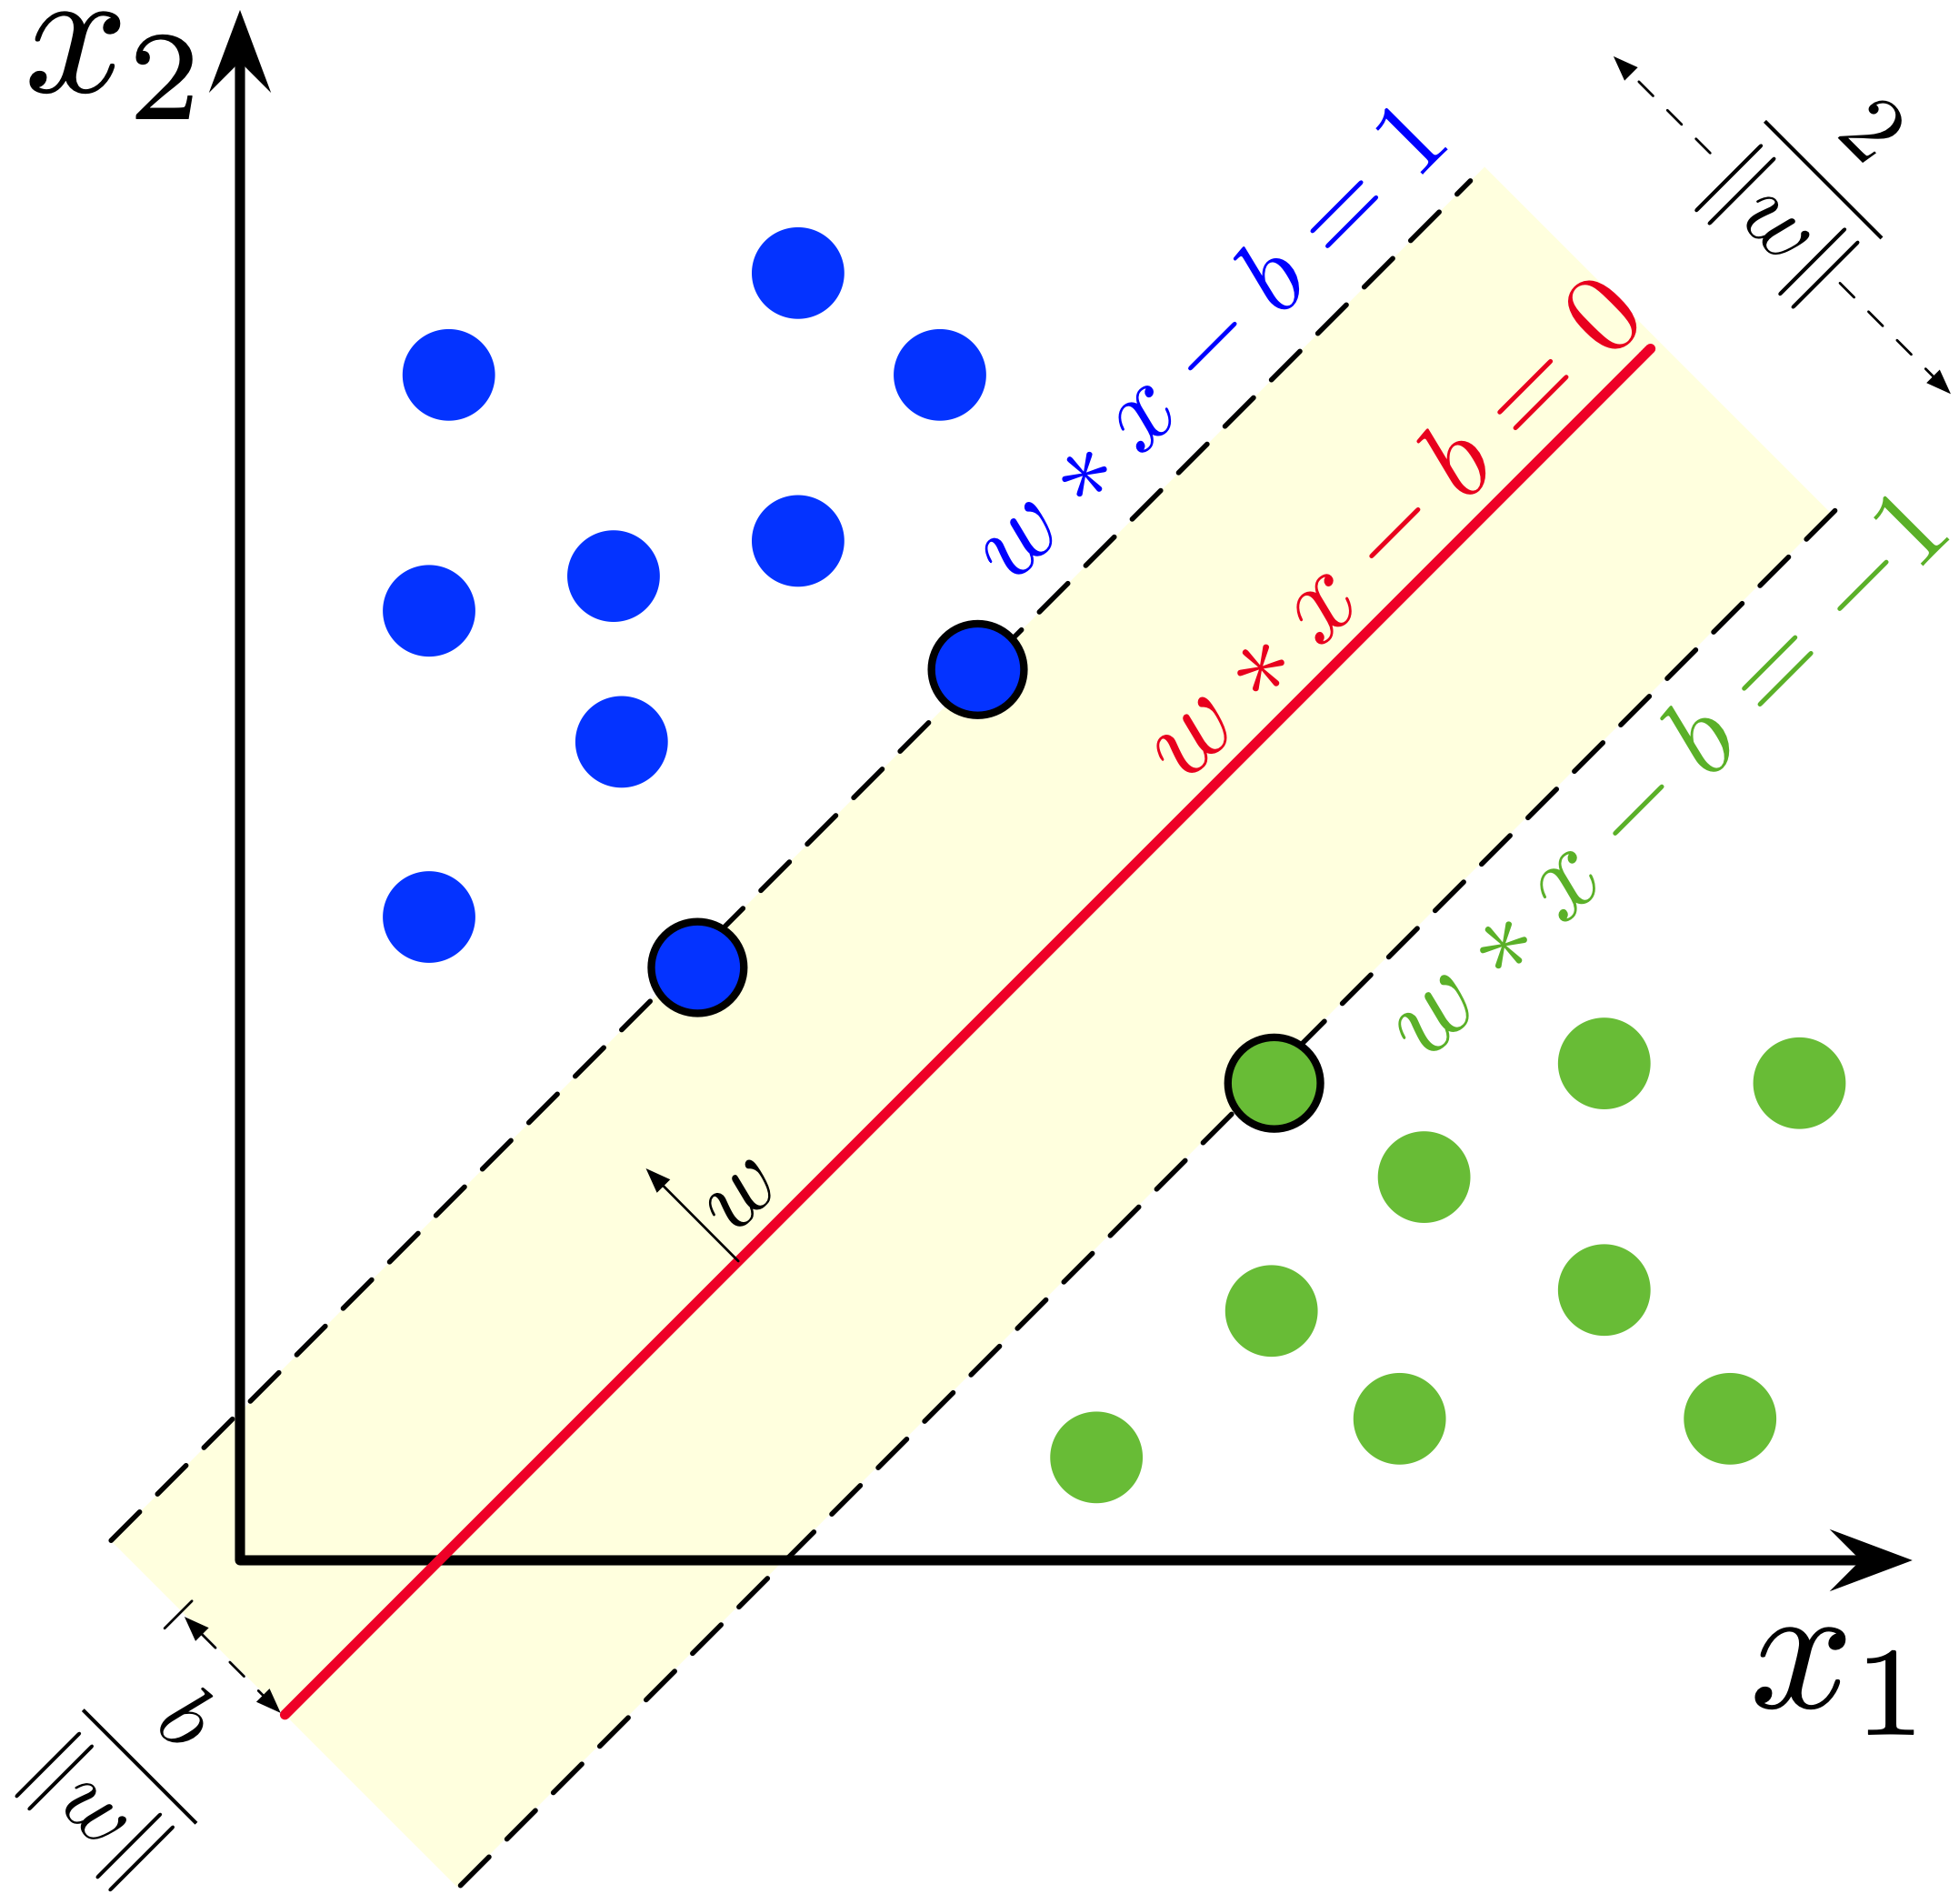

In [21]:
img = Image.open('../images/SVM_margin.png')
display(img)


#### Hyperplane

$ W^{T} - b = 0$

#### Hard-margin 

When the training data is linearly separable, we can select two parallel lines that maximises the margin, this can be described by equations as: 

$ W^{T} - b = 1$ (anything on or **above** the boundary of one class is labeled 1

$ W^{T} - b = -1$(anything on or **below** the boundary of one class is labeled -1

$W^{T}X_{i} -b \geq 1$, if $y_{i} = 1$

$W^{T}X_{i} -b \leq -1$, if $y_{i} = -1$

This can be written as

$y_{i}(W^{T}X_{i} - b) \geq 1$ for all $1 \leq i \leq n$

Now let’s try to understand the above equation:

- When y = 1 then distance (Wx + b) will also be positive (let’s say +1). So y*dist →1 (+ve value) * 1 (+ve value) = +ve value.
- When y = -1 then the distance will also be negative (let’s say -1). So y*dist→ -1(-ve value) * -1 (-ve value) = +ve value.


#### Soft-margin
To extend the SVM to cases in which the data are not linearly separable the ***hinge loss*** function is helpful: 

$$max(0, 1-y_{i}(W^{T}X_{i} - b))$$

Interpretation of this: this function is set to 0 if $y_{i}(W^{T}X_{i} - b) \geq 1$ for all $1 \leq i \leq n$ is satisfied, in other words $X_{i}$ lies on the correct side of the margin. For data on the wrong side of the margin, the function's value is propositional to the distance from the margin. The goal of the optimisation then is to minimize this function, which is in term called the cost function. 




In [22]:
import os
os.getcwd()

'/Users/jessie/github/algo_ecg/notebooks'

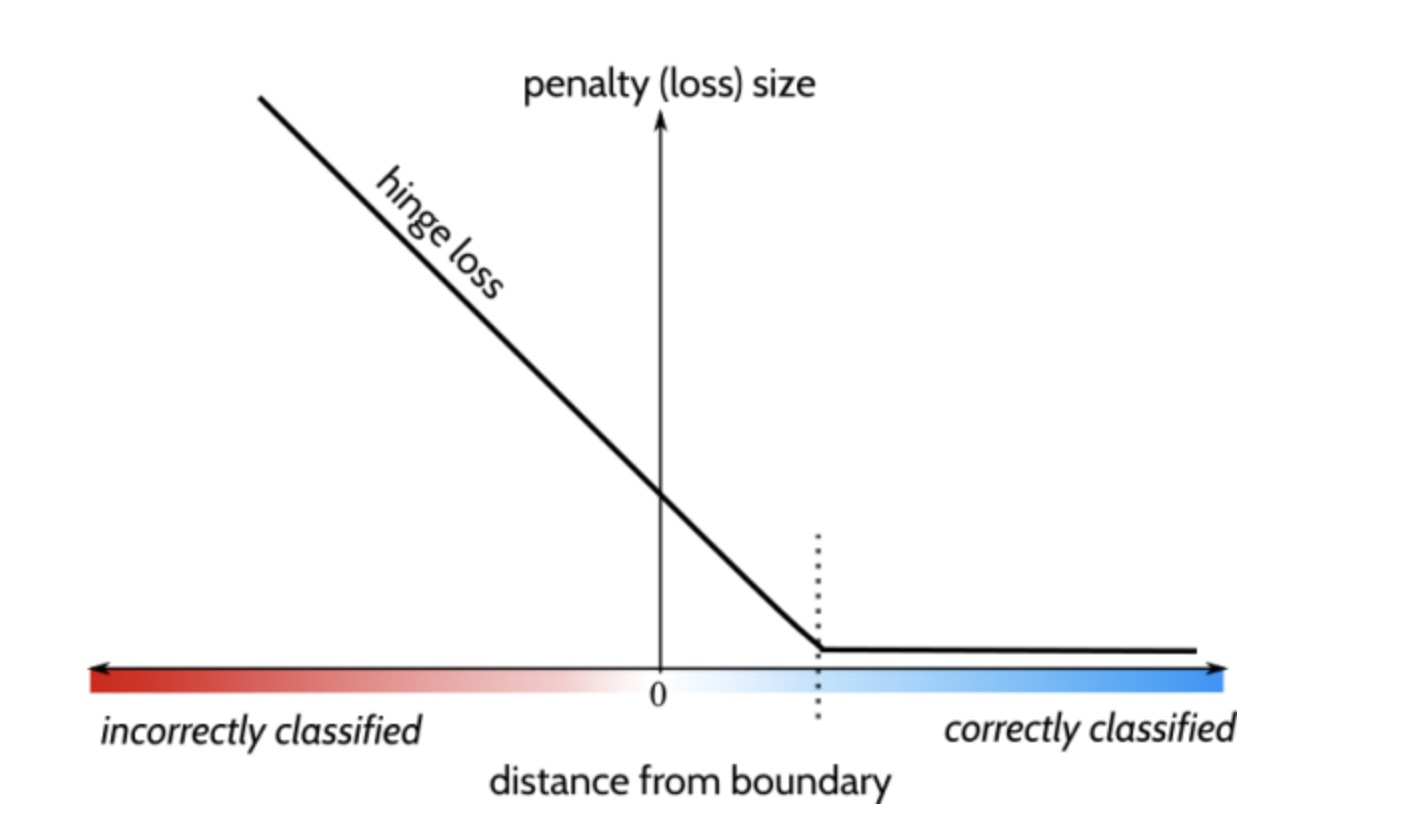

In [23]:
img = Image.open('../images/SVM_hinge_loss.jpg')
display(img)

#https://math.stackexchange.com/questions/782586/how-do-you-minimize-hinge-loss


### Cost function of SVM



$$\lambda \|W\|^{2} + \sum_{i=1}^{n}max(0, 1 - y_{i} (W^{T}x_{i} - b)) $$

where 

$W$ weights

$\lambda$ is a regularisation parameter. It determines the trade-off between increasing the margin size and  and ensuring that the $x_{i}$ lie on the correct side of the margin. It is inversely related to $C$

#### Cost function can be massaged to below
$$\min \frac{1}{2} \|W\|^{2} + C \sum_{i=1}^{n}max(0, 1 - y_{i} (W^{T}x_{i} - b)) $$


#### Gradients - to update weights and bias
if $y_{i} (W^{T}x_{i} - b) >=1$: 

loss is zero, data is correctly classified, not weight update

$\frac{\partial J}{\partial w} = 0$

$\frac{\partial J}{\partial b} = 0$

$w = w$

$b = b$

if $y_{i} (W^{T}x_{i} - b) <1$: 

loss is not zero but subject to < 1, data is wrongly classified with an error margin: 

$\frac{\partial J w_{i}}{\partial w_{i}} = -C y_{i}x_{i} $

$\frac{\partial J b}{\partial b} = -C y_{i} $

$w = w - \alpha (w - C y_{i} x_{i}) $

$b = b + \alpha C y_{i}$


#### Non-linear kernels

$$\min \frac{1}{2} \|W\|^{2} + C \sum_{i=1}^{n}max(0, 1 - y_{i} (W^{T}x_{i} - b)) $$


##### Polynomial 

$$k(X_{i}, X_{j}) = (X_{i}X_{j} + 1)^d$$ where $d$ is the degree of polynomial

##### Gaussian radical basis function

$$k(X_{i}, X_{j}) = exp(-\gamma\|X_{i}-X_{j}\|^2)$$


## Implementation

In [51]:
# Load data
#X_in, y = algo_ecg.data.import_physionet_data('../data', num_files_to_read=1000)
#X = algo_ecg.preprocessing.preprocess(X_in)
X_in, y, pids = algo_ecg.data.import_physionet_data('/Users/jessie/data/PhysioNet_CinC', num_files_to_read=1000)
X, pids = algo_ecg.preprocessing.preprocess_pid(X_in, pids)
#slice_length = len(X[0])
#X = np.concatenate(X).reshape(-1, slice_length, 1)
#X = pd.DataFrame.from_records(X)


In [52]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=.7)

In [53]:
slice_length = len(X_train[0])
X_train = np.concatenate(X_train).reshape(-1, slice_length, 1)
X_test = np.concatenate(X_test).reshape(-1, slice_length, 1)

In [54]:
X_train_pd = pd.DataFrame.from_records(X_train)
X_test_pd = pd.DataFrame.from_records(X_test)
                 

In [55]:
pipe = Pipeline(steps=[
#    ('peaks', FindPeaksCustomTransformer (axis=1)), 
    ('features_all',AllFeatureCustomTransformer(axis = 1)), 
    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['pNN50','RMSSD_ms']})),
    ('standardscaler', StandardScaler())
])


In [56]:
X_train_pd_transform = pipe.fit_transform(X_train_pd)
X_test_pd_transform = pipe.fit_transform(X_test_pd)

In [57]:
X_train_pd_transform
y_train

y_train_t = np.where(y_train == 0, -1, 1)
y_test_t = np.where(y_test == 0, -1, 1)



In [58]:
print(X_train_pd_transform.shape, len(y_train))

(482, 2) 482


In [59]:
from algo_ecg.SVM_gradient_descent import SVM, SVM_classifier

svm = SVM(C = 1)

w, b, losses = svm.fit(X_train_pd_transform, y_train_t, \
                      batch_size=100, learning_rate=0.001, epochs=1000)

In [41]:
prediction = svm.predict(X_test_pd_transform)

# Loss value
lss = losses.pop()

print("Loss:", lss)
#print("Prediction:", prediction)
print("Accuracy:", accuracy_score(prediction, y_test_t))
print("w, b:", [w, b])

Loss: 1.4996944023655965
Accuracy: 0.9423076923076923
w, b: [array([[ 1.73367435, -0.12222238]]), -2.4139999999997532]


In [49]:
def visualize_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)


# Visualizing SVM
def visualize_svm(X_test, y_test, w, b):

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0][0] * x + b + offset) / w[0][1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test, alpha=0.5)

    x0_1 = np.amin(X_test[:, 0])
    x0_2 = np.amax(X_test[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X_test[:, 1])
    x1_max = np.amax(X_test[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

In [64]:
svm2 = SVM2(learning_rate=0.001, no_of_iterations=1000, lambda_parameter = 0.01)

In [65]:
svm2.fit(X_train_pd_transform, y_train)

In [66]:
np.reshape(svm2.w, (-1, 2))


array([[ 1.49143293, -0.14211404]])

In [67]:
prediction = svm2.predict(X_test_pd_transform)

In [68]:
print("Accuracy:", accuracy_score(prediction, y_test))

Accuracy: 0.9567307692307693


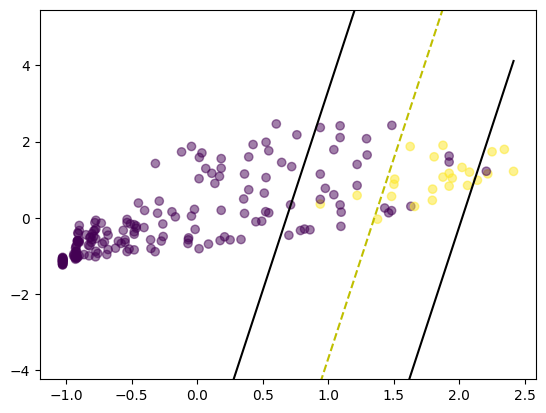

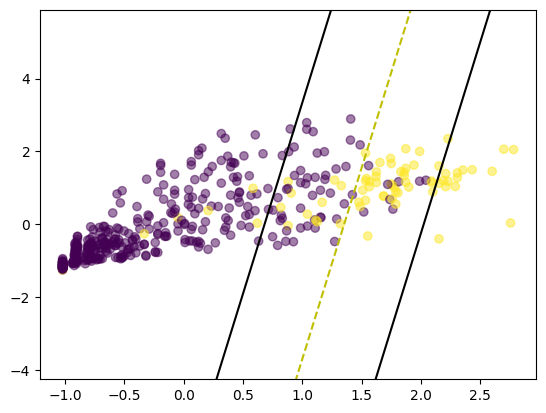

In [69]:
visualize_svm(X_test_pd_transform, y_test_t, np.reshape(svm2.w, (-1, 2)), svm2.b)
visualize_svm(X_train_pd_transform, y_train_t, np.reshape(svm2.w, (-1, 2)), svm2.b)